# Distributional Semantics Tasks

Distributional semantics is one of the modern methods in natural language processing in solving tasks that require semantic knowledge of a word or relations between words. This project includes two parts.

* Part 1: Create distributional semantic word vectors by using PPMI

* Part 2: Use existed word vectors to solve semantic tasks, including synonym detection and SAT analogy questions.

In [1]:
import os
import numpy as np
import scipy.linalg as scipy_linalg
from collections import defaultdict 
import pandas as pd
import random
import re
import json

#os.chdir('C://Users/wanyu/Documents/Computational Linguilistics/PA5')

# Part 1. Create distributional semantic word vectors

In [2]:
class DSWC():
    
    def __init__(self, word_dict=None, ppmi_matrix=None):
        self.word_dict = word_dict
        self.freq_matrix = None
        self.ppmi_matrix = ppmi_matrix
        self.V = None    

        
    def PPMI(self, sentences):
        
        # Create a word dictionary
        words = []
        for sentence in sentences:
            words.extend(sentence)
        
        words = list(set(words))
        self.word_dict = {word: index for index, word in enumerate(words)}
        
        # Creating a co-occurence matrix
        self.freq_matrix = np.zeros((len(words), len(words)))
        
        for sentence in sentences:
            for index, word in enumerate(sentence):
                if index != 0: 
                    context_idx = self.word_dict[sentence[index-1]]
                    word_idx = self.word_dict[word]
                    self.freq_matrix[word_idx, context_idx] += 1

        # Repeating sentnences and Smoothing counts            
        self.freq_matrix = self.freq_matrix*10 + 1

        total = self.freq_matrix.sum().sum()
        
        # Computing PPMI
        join_prob = self.freq_matrix/total
        word_prob = self.freq_matrix.sum(axis=1)/total
        context_prob = self.freq_matrix.sum(axis=0)/total
        
        independent_prob = (word_prob[:,None]*context_prob).T
        self.ppmi_matrix = np.log(join_prob*(1/independent_prob))
        
        self.ppmi_matrix = np.maximum(self.ppmi_matrix, np.zeros((len(self.word_dict), len(self.word_dict))))

    def SVD(self):
        U, E, Vt = scipy_linalg.svd(self.ppmi_matrix, full_matrices=False)
        U = np.matrix(U) # compute U
        E = np.matrix(np.diag(E)) # compute E
        Vt = np.matrix(Vt) # compute Vt = conjugage transpose of V
        
        return Vt.T # compute V = conjugate transpose of Vt
    
    def reduced_PPMI(self, dimension):
        self.V = self.SVD()
        reduced_PPMI = self.ppmi_matrix * self.V[:, 0:dimension]
        
        return reduced_PPMI
    
    def word_vector(self, words, word_matrix=None):
        '''
        Get a word vector based on the default matrix
        '''
        
        if word_matrix is None:
            word_matrix = self.ppmi_matrix                  
        
        if type(words) == list:
            word_index = [self.word_dict[word] for word in words]
            word_vector = word_matrix[word_index].astype('float')
            
        else: 
             word_index = self.word_dict[words]
        
        word_vector = word_matrix[word_index]
        
        return word_vector
    
    
    def euclidean(self, word1, word2, word_matrix=None, v_input=False):
        
        '''
        Compute the Euclidean distance between two vectors
        '''
        
        if word_matrix is None:
            word_matrix = self.ppmi_matrix   
        
        if v_input:
            v1, v2 = word1, word2
        
        else:
            v1 = self.word_vector(word1, word_matrix)
            v2 = self.word_vector(word2, word_matrix)
        
        distance = scipy_linalg.norm(v2-v1)
        
        return distance
    
    def cosine_similarity(self, word1, word2, word_matrix=None, v_input=False):
        '''
        Compute the cosine similarity between two words or one word and several words
        '''
        
        if word_matrix is None:
            word_matrix = self.ppmi_matrix   
        
        if v_input:
            v1, v2 = word1, word2
        
        else:
            v1 = self.word_vector(word1, word_matrix)
            v2 = self.word_vector(word2, word_matrix)
            
        length_v1 = scipy_linalg.norm(v1)
        length_v2 = scipy_linalg.norm(v2, axis=1)
        denominator = length_v1 * length_v2
        numerator = np.squeeze(np.asarray(v1.dot(v2.T)))
        similarity = numerator*(1/denominator)
        
        return similarity  
   

In [3]:
# Read files
with open('dist_sim_data.txt') as f:
    sentences = f.read().splitlines()
    sentences = [sentence.split() for sentence in sentences]

In [4]:
dswc = DSWC()        
dswc.PPMI(sentences)

dogs = pd.DataFrame({'Raw Counts': dswc.word_vector('dogs', dswc.freq_matrix).ravel(), 
                   'PPMI': dswc.word_vector('dogs').ravel()}, index=list(dswc.word_dict.keys()))
dogs.T.round(2)

,women,dogs,the,like,feed,bite,men
Raw Counts,1.0,1.0,91.00,1.0,1.0,1.0,1.0
PPMI,0.0,0.0,2.09,0.0,0.0,0.0,0.0


As we can see in the above table, PPMI indeed improves the measurement of the association between words. Instead of directly using raw counts, it captures how much more the two words co-occur than two words appear by chance. Therefore, it can discriminate against essential words.

In the raw count vector, the context word, "the", has the highest frequency, and its value is also other than 1 compared to other context words. The PPMI vector has similar results, and only "the" has a non-zero value. However, the range between "the" and other context words become smaller in the PPMI vector. Therefore, PPMI can not only correctly discriminate important words but also mitigate a skewed problem of raw counts. Because "the" are ubiquitous in all sentences, the prior
probability of "the" will be high, and the independent probability of "dogs" and "the" will also be high. Thus, the importance of "the" will significantly decrease. Although "the" is not the right word to differentiate "dogs" with other nouns, it can help us to discriminate it with other parts-of-speech, such as verbs. That's the reason why "the" still has a certain amount of PPMI.

In [5]:
sim_original,sim_reduced = [], []
pairs = [['women','men'],['women','dogs'],['men','dogs'],
         ['feed','like'],['feed','bite'], ['like','bite']]
reduced_PPMI = dswc.reduced_PPMI(3)

for pair in pairs:
    original = round(float(dswc.euclidean(pair[0], pair[1])),4)
    reduced = round(float(dswc.euclidean(pair[0], pair[1], reduced_PPMI)),4)
    sim_original.append(original)
    sim_reduced.append(reduced)
    
pairs_text = ['_'.join(pair) for pair in pairs]
distance = pd.DataFrame({'pairs':pairs_text, 'compact PPMI': sim_original,
                          'reduced PPMI': sim_reduced})

distance.set_index('pairs')

,compact PPMI,reduced PPMI
pairs,,
women_men,0.2234,0.2234
women_dogs,0.3398,0.3398
men_dogs,0.1164,0.1164
feed_like,0.6674,0.5220
feed_bite,2.1746,2.1701
like_bite,1.7205,1.6985


There are two interesting facts we can notice from the above tables:

First, the distances reflect the fact that similar words appear in similar contexts.The first three pairs are all nouns and have similar distances because their contexts are the same word, "the". Although "men" seems more closer to "dogs" than to "women", it might result from the difference of the total frequency in our dataset. If we compute how many times those nouns are shown in our dataset, we can discover that "dogs" appears 91 times, "men" occurs 81 times and "women" only shows 51 times. Thus, we can conclude that the differences of distance here between nouns are determined by how often a word appears in all sentences.
Although human-related and animal-related nouns don't have a significant difference, we can see the apparent disparity between human-related and animal-related verbs. Since both "feed" and "like" belong to human-related verbs, they should be close to each other but be far from the animal-related verb. This fact is revealed by the above measurement of distance.

Second, the reduced PPMI remains most information for each word vector(the above table).
Although only the distance between "feed" and "like" decreases slightly, it still reflects
that "feed" and "like" are closer to each other and don't influence the results.

# 2. Synonym Detection

* **Objective:** Use two types of word vectors to conduct synonym detection.

* **Description of Word Vectors:**
  1. **Classic distributional semantic matrix**: The matrix is trained using a 2-word context window, PPMI weighting, and SVD reduction to 500 dimensions. The co-occurrence statistics are computed from the British National Corpus and the Web-As-Corpus. It is trained by the COMPOSES toolkit. You could in fact make your own using the pipeline from part I, but SVD takes hours in a realistic setting|cubic time (O(n3)) in the number of dimensions.
  2. **Google’s 300-dimensional word vectors** trained by deep learning. The version we provide is trained on the Google News corpus and taken from the word2vec toolkit. We will see how their word vectors fare against the more classical method.

* **Tasks:**  
  1. Create a multiple-choice question test set: For each verb, you will pick 1 of the synonyms and 4 random non-synonyms from the data set. Make 1,000 such synonym multiple-choice questions. 
  2. Use the word vectors and to calculate **Euclidean distance** and **cosine similarity** to pick the synonym out of the 5 alternatives for each verb and compute the accuracy. 

In [6]:
# Import classic and google word vectors
google_dict, classic_dict = defaultdict(int), defaultdict(int)

with open('EN-wform.w.2.ppmi.svd.500.rcv_vocab.txt') as f:
    classic_list = f.read().splitlines()
    
for index, vector in enumerate(classic_list):
    word_vector = vector.split(' ')
    classic_dict[word_vector[0]] = len(classic_dict)
    classic_list[index] = word_vector[1:]

with open('GoogleNews-vectors-rcv_vocab.txt') as f:
    google_list = f.read().splitlines()

for index, vector in enumerate(google_list):
    word_vector = vector.split(' ')
    google_dict[word_vector[0]] = len(google_dict)
    google_list[index] = word_vector[1:]

# Transform lists to matrices
classic_matrix = np.matrix(classic_list).astype('float')
google_matrix = np.matrix(google_list).astype('float')

In [7]:
# Define google matrix and classic matrix
google = DSWC(google_dict, google_matrix)
classic = DSWC(classic_dict, classic_matrix)

In [8]:
# Import synonym questions
questions = json.load(open("synonyms_questions.txt"))

In [9]:
# Use google matrix and classic matrix to answer a synonym for each question
accuracy_synonyms = [0] * 4

for index, values in questions.items():   
    sim_google = google.cosine_similarity(values['question'], values['choice'])
    sim_classic = classic.cosine_similarity(values['question'], values['choice'])
    dist_google = google.euclidean(values['question'], values['choice'])
    dist_classic = classic.euclidean(values['question'], values['choice'])
    ans_list = [sim_google.argmax(), sim_classic.argmax(), dist_classic.argmin(), dist_classic.argmin()]
    for index, ans in enumerate(ans_list):
        if ans == 0:
            accuracy_synonyms[index] += 1
            
synonyms_detections =  pd.DataFrame(accuracy_synonyms, columns=['Accuracy'],
                                    index=['cos_google', 'cos_classic', 'dist_google', 'dist_classic'])/1000

In [10]:
synonyms_detections

,Accuracy
cos_google,0.627
cos_classic,0.537
dist_google,1.000
dist_classic,1.000


Obviously, Euclidean distance performs better in synonyms detections than cosine
similarity. The former can correctly answer the question and gain 100%
accuracy. As for COMPOSES and word2vec, if we look at the performance of cosine
similarity, the Google matrix(word2vec) seems to have relatively better performance than
the classic matrix(COMPOSES). (Accuracy: 62.7% > 53.7%)

# 3. SAT Analogy Questions

* **Objective:** Use word vectors to solve 374 SAT Analogy Questions

* **Sample SAT Question:**

Questions: MEDICINE : ILLNESS</br>
(a) law : anarchy</br>
(b) hunger : thirst</br>
(c) etiquette : discipline</br>
(d) love : treason</br>
(e) stimulant : sensitivity</br>

Correct Answer: (a)

In [11]:
# Import SAT questions
answer_dict = {answer: index for index, answer in enumerate(['a','b','c','d','e'])}
sat_questions = defaultdict(dict)
with open('SAT-package-V3.txt') as f:
    sat = f.readlines()[42:]
    
for i in range(1,3364,9):
    index = len(sat_questions)
    sat_questions[index]['question'] = re.findall(r'[^\W]+', sat[i])[:2]
    choice_list = []
    for choice in sat[(i+1):(i+6)]:
        choice_list.append(re.findall(r'[^\W]+',  choice)[:2])
    sat_questions[index]['choice'] = choice_list
    sat_questions[index]['answer'] = answer_dict[sat[i+6][0]]

In [12]:
# Define the function to summarize the relation between two words
def vec_summary(v1, v2, mode):
    if mode == 0:
        vec = v1+v2
    elif mode == 1:
        vec = v1-v2
    elif mode == 2:
        vec = np.multiply(v1,v2)
    elif mode == 3:
        vec = np.multiply(v1,1/v2)
    elif mode == 4:
        vec = np.concatenate((v1,v2),axis=1)
    return vec

In [13]:
# Use cosine similarity to measure similarity
results = {'Classic':[], 'Google':[]}
for m in range(5):
    accuracy_list_google = np.array([])
    accuracy_list_classic = np.array([])

    for index, values in sat_questions.items():
        w1, w2 = values['question']
        q1 = vec_summary(classic.word_vector(w1),classic.word_vector(w2),m)
        q2 = vec_summary(google.word_vector(w1),google.word_vector(w2),m)
        sim_list_classic, sim_list_google = np.array([]), np.array([])
        for choice in values['choice']:
            w1, w2 = choice
            c1 = vec_summary(classic.word_vector(w1), classic.word_vector(w2),m)
            c2 = vec_summary(google.word_vector(w1), google.word_vector(w2),m)
            sim_list_classic = np.append(sim_list_classic, classic.cosine_similarity(q1,c1,v_input=True))
            sim_list_google = np.append(sim_list_google, google.cosine_similarity(q2,c2,v_input=True))


        accuracy_list_classic= np.append(accuracy_list_classic, sim_list_classic.argmax() == values['answer'])
        accuracy_list_google= np.append(accuracy_list_classic, sim_list_google.argmax() == values['answer'])


    results['Classic'].append(accuracy_list_classic.mean().round(4))
    results['Google'].append(accuracy_list_google.mean().round(4))

sat_cos = pd.DataFrame(results, index=['Addition', 'Subtraction', 'Multiplication', 'Division', 'Concatenation'])

C:\Users\wanyu\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\wanyu\anaconda3\lib\site-packages\ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in multiply


In [14]:
# Use the Euclidean Distance to measure similarity
results = {'Classic':[], 'Google':[]}
for m in range(5):
    accuracy_list_google = np.array([])
    accuracy_list_classic = np.array([])

    for index, values in sat_questions.items():
        w1, w2 = values['question']
        q1 = vec_summary(classic.word_vector(w1),classic.word_vector(w2),m)
        q2 = vec_summary(google.word_vector(w1),google.word_vector(w2),m)
        sim_list_classic, sim_list_google = np.array([]), np.array([])
        for choice in values['choice']:
            w1, w2 = choice
            c1 = vec_summary(classic.word_vector(w1), classic.word_vector(w2),m)
            c2 = vec_summary(google.word_vector(w1), google.word_vector(w2),m)
            sim_list_classic = np.append(sim_list_classic, classic.euclidean(q1,c1,v_input=True))
            sim_list_google = np.append(sim_list_google, google.euclidean(q2,c2,v_input=True))


        accuracy_list_classic= np.append(accuracy_list_classic, sim_list_classic.argmin() == values['answer'])
        accuracy_list_google= np.append(accuracy_list_classic, sim_list_google.argmin() == values['answer'])


    results['Classic'].append(accuracy_list_classic.mean().round(4))
    results['Google'].append(accuracy_list_google.mean().round(4))
sat_dist = pd.DataFrame(results, index=['Addition', 'Subtraction', 'Multiplication', 'Division', 'Concatenation'])

In [15]:
sat_dist

,Classic,Google
Addition,0.3102,0.3120
Subtraction,0.3824,0.3840
Multiplication,0.2594,0.2587
Division,0.2032,0.2053
Concatenation,0.3904,0.3920


**Explanation**

To obtain a relation between two words within a question and its choices, I tried several methods, including division, multiplication, addition, concatenation, and subtraction. 

Subsequently, I compared those relations through computing their cosine similarity and
Euclidean distance and chose the maximum value for cosine similarity and the minimum
values for Euclidean distance. Besides, each method adopted two kinds of word
matrices, the Classic matrix (COMPOSES) and the Google matrix (word2vect),
respectively, to conduct computation. Finally, by calculating the accuracy for each
method, the results are shown in the above table.

In [16]:
# Turn the results into a table and compare them
sat_dist['Similarity'] = 'Euclidean Distance'
sat_cos['Similarity'] = 'Cosine Similarity'
sat_comparison = pd.concat([sat_dist, sat_cos]).reset_index().rename(columns={'index':'Aggregation Method'})

sat_comparison = pd.melt(sat_comparison, id_vars=['Similarity','Aggregation Method'], value_vars=['Classic', 'Google'], var_name='Word Matrix', value_name='Accuracy')
#sat_comparison.iloc[:, [2,3,0,1,4]]
#sat_comparison.groupby(['method','word_matrix','index']).mean().unstack(level=2)
sat_comparison = pd.pivot_table(sat_comparison, index=['Similarity','Word Matrix'], columns='Aggregation Method', aggfunc=np.mean)
sat_comparison.iloc[:,[2,3,0,1,4]]

Accuracy                                        \
Aggregation Method             Division Multiplication Addition Concatenation   
Similarity         Word Matrix                                                  
Cosine Similarity  Classic       0.1818         0.2353   0.3235        0.3904   
                   Google        0.1813         0.2373   0.3253        0.3920   
Euclidean Distance Classic       0.2032         0.2594   0.3102        0.3904   
                   Google        0.2053         0.2587   0.3120        0.3920   

                                            
Aggregation Method             Subtraction  
Similarity         Word Matrix              
Cosine Similarity  Classic          0.4225  
                   Google           0.4213  
Euclidean Distance Classic          0.3824  
                   Google           0.3840

In order to clearly identify the best method, I visualized the results through the parallel coordinate plot and presented it in ​Figure 1​. Each vertical line represents the method for computing a relation between two words. Color lines exhibit the accuracy of different similarity methods. Red lines are cosine similarity whereas blue lines are Euclidean distance.

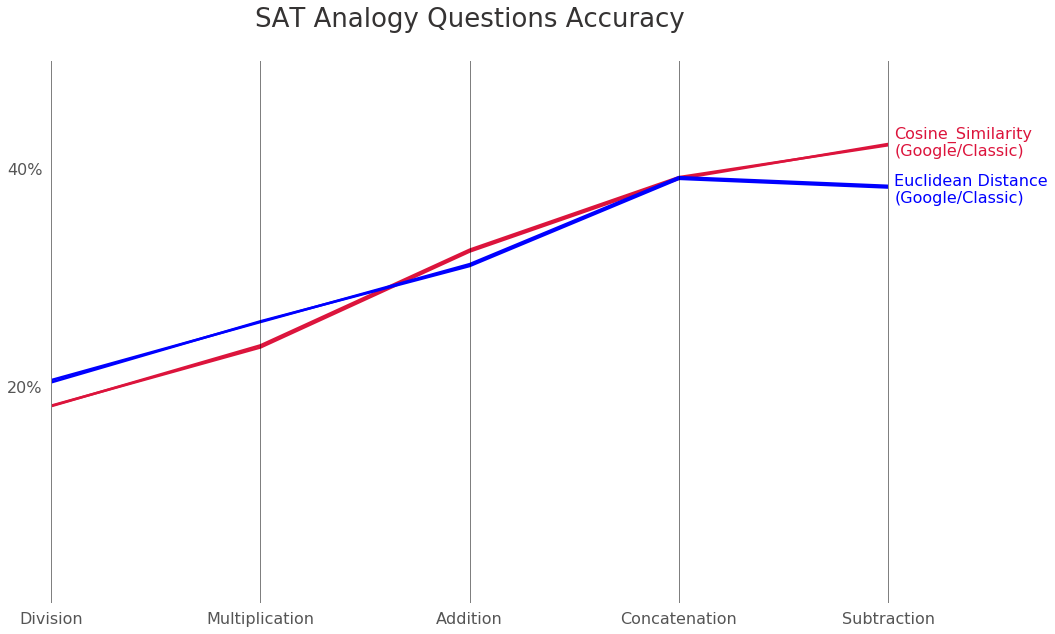

In [21]:
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
sat_plot = sat_comparison.stack(level=0).reset_index()
sat_plot['line_name'] = sat_plot.loc[:, ['Similarity', 'Word Matrix']].agg('_'.join, axis=1)
sat_plot.iloc[:,[5,6,3,4,7,8]]

# Make the plot
plt.style.use('ggplot')
plt.figure(figsize=[15,10]) 
p = parallel_coordinates(sat_plot.iloc[:,[5,6,3,4,7,8]], 
                         'line_name', 
                         color=['crimson', 'crimson', 'blue', 'blue'], #colormap=plt.get_cmap("Accent")
                         axvlines=False,
                         linewidth=2.5)

p.set_facecolor('white')
p.spines['right'].set_color('0.5')
p.spines['left'].set_color('0.5')
for i in range(1,4,1):
    plt.axvline(x=i, linewidth=0.5, color='black')
plt.yticks(np.arange(0.2, 0.6, step=0.2))
p.tick_params(axis='both', which='both', width=0, pad=5, color='white')
plt.xticks(fontsize=16)
p.set_yticklabels([str(i)+'%' for i in range(20,61,20)])
plt.yticks(fontsize=16)
plt.text(4.03, sat_plot.loc[0,'Subtraction']+0.005, 'Cosine_Similarity', color='crimson', fontsize=16)
plt.text(4.03, sat_plot.loc[0,'Subtraction']-0.01, '(Google/Classic)', color='crimson', fontsize=16)
plt.text(4.03, sat_plot.loc[3,'Subtraction'], 'Euclidean Distance', color='blue', fontsize=16)
plt.text(4.03, sat_plot.loc[3,'Subtraction']-0.015, '(Google/Classic)', color='blue', fontsize=16)
plt.legend().remove()
plt.title('SAT Analogy Questions Accuracy', fontsize=26, y=1.05, color='#353333')
plt.ylim(0,0.5)
plt.show()

We can notice that the best combination is to use the subtraction method and cosine
similarity. For analogy questions, there is somehow a correlation between two words, but we might not be able to describe it as a positive or negative relationship. Take a
question, "ostrich" and " bird" as an example. "Ostrich" is one kind of "birds''. That is, "ostrich" belongs to the "bird" category. Therefore, the best answer is "lion and cat" because "lion" can also be classified into the "cat" category. The relationship between two words is that one word is a general concept, and the other word is a specific example of the concept. To capture this kind of relation, we can compute how much difference two word vectors have through the subtraction method. Besides, when using the subtraction method, the cosine similarity method has a better effect than Euclidean distance. Because subtraction summarizes a relation of two words into a vector and keeps a property of direction. The cosine similarity can recognize whether two vectors have a similar direction, but Euclidean distance only identifies the distance between two vectors. However, when using the concatenating method, because we kept all information from two words, Euclidean distance and cosine similarity had equivalent performances. Therefore, different aggregating methods should combine different similarity methods to optimize the performance

As for the word matrices, the Classic matrix has similar performance with the Google
matrix in no matter what method we use. For the best method ( subtraction and cosine
similarity), the Classic matrix slightly better than the Google matrix (0.4225 > 0.4213).Overall, the numbers of entries in a vector will not cause a significant influence on
accuracy.